In [1]:
%matplotlib widget
import sys
import os 
import pickle

from ece4078.localization.dynamic_system_import import import_based_on_version
import_based_on_version(globals(), locals())
from ece4078.localization.Renderer import *

sys.path.insert(0, os.path.abspath('Practical03_Support'))
from Measurements import *

# Coding Exercise: SLAM EKF (7 points)

Given the EKF theory covered during the lecture, we will try to implement it here. Please consult the lecture slide for useful resources.

The following cell will try to import data that ran on actual robot.

- `measurements_replay` is a Python list of `MarkerMeasurement` being replayed. `MarkerMeasurement` is a data-only class that has properties: `position`, `tag` containing the tag number, and `covariance` containing the uncertainty that one specific measurement.
- `control_replay` is a Python list of control signal being replayed. 
- `lm` stands for landmark
- `P` is initialization for $\Sigma_k$
- `sigma_drive` is the uncertainty in the left and right wheel, not the uncertainty of the motion model $\Sigma_Q$
- `sigma_measure` is the uncertainty in one particular landmark, a collection of different `sigma_measure` will make up the measurement uncertainty $\Sigma_R$
- `state` is a list that contains all the state we have estimated so far.
- `robot_cov` is a list that contains all the covariance we have estimated so far.

In [2]:
with open('Practical03_Support/data/data_ekf.dat', "rb") as f:
    data = pickle.load(f)

# Setup our robot
bot = PenguinPi(0.14, 0.01)
gt_state = data['state']
control_replay = data['control']
measurements_replay = data['measurement']
# Here are our true marker positions
markers = data['markers']

# Set the initial state of the robot from the data
init_x, init_y, init_theta = gt_state[0,:]
bot.set_state(x=init_x, y=init_y, theta=init_theta)

#----------------------------------PARAMETERS--------------------------------------
# Initial incertainty of our robot
P = np.eye(3)*100
# Uncertainty in our left and right wheel motors
sigma_drive = np.array([10,10])
# Uncertainty in measurement
sigma_measure = np.eye(2)*100
#-----------------------------------------------------------------------------------

# Apply our control to the robot and visualize
# Our timestamp is always 0.2
dt = 0.2
# Here we will save our state variable 
state = np.zeros((control_replay.shape[0],3))
# Here we save the robot covariances
robot_cov = np.zeros(((control_replay.shape[0],3,3)))

First, we will do the predict step:
- In here `bot.drive` will evaluate the next state using the motion model depending on the `drive_signal`, `x_bar` is $\bar{\mu}_k$ in the lecture slide
- `derivative_drive` and `covariance_drive` will obtain `A` and `Q` which is $A$ and $\Sigma_Q$ in the lecture slide
- Your job is to find $\bar{\Sigma}_k$ which is variable `P` in this code.

In [3]:
def predict_step(bot, prev_P, drive_signal):
     # 1. Predict state
    bot.drive(drive_signal)
    x_bar = np.array(bot.get_state()).reshape((3,1))
    # 2.. Linearize about prediction
    A = bot.derivative_drive(drive_signal)
    # 3. Get covariance
    Q = bot.covariance_drive(drive_signal)
    # 4. Predict covariance
    
    #TODO: Complete this step -----------------------------------------------------
    P = A @ prev_P @ A.T + Q
    #ENDTODO ----------------------------------------------------------------------

    return P, x_bar

We want to construct $\Sigma_R$. $Sigma_R$ is a square matrix of $2n\times2n$ where n is the number of measurements. It is $2n$ because there is 2 degrees of freedom for each measurement: $x$ and $y$ position of the landmark.

The structure of $\Sigma_R$ is
$$
\Sigma_R = \begin{bmatrix}
                \Sigma_{m_1} & 0 & 0 &0\\
                0 & \Sigma_{m_2} & 0 &0\\
                0 & 0 & \ddots &0\\
                0 & 0 & 0 & \Sigma_{m_n}\\
            \end{bmatrix}
$$
where $\Sigma_{m_i}$ is the covarinance matrix of the $i^{th}$ measurement of the current time step.

In this code, `z` is $z_k$ and `R` is $\Sigma_R$ in the lecture slide.

In [4]:
def construct_R(measurements):
    # Stack measurements and set covariance
    z = np.concatenate([lm.position.reshape(-1,1) for lm in measurements], axis=0)

    #TODO: Complete this step -----------------------------------------------------
    # Calculate the diagonal elements of the covariance matrix manually
    num_measurements = z.shape[0]

    R = np.zeros((num_measurements, num_measurements))

    for i in range(len(measurements)):
        R[2*i:2*i+2,2*i:2*i+2] = measurements[i].covariance
        #print(measurements[i].covariance)
        
    return z, R

- `bot.derivative_measure` and `bot.measure` will obtain `C` and `z_hat` which is $C$ and $\mathbf{h}(\bar{\mu}_k)$ in the lecture slide
- You have to construct the Kalman gain `K`
- Then calculate the `corrected_x` which is $\mu_k$ in the lecture slide
- Finally, update `corrected_P` which is $\Sigma_k$ in the lecture slide

In [5]:
def update_step(bot, P, R, z, x_bar, tags):
    # 1. Get location of measurements given robot's current state
    z_hat = bot.measure(markers, tags)
    z_hat = z_hat.reshape((-1,1),order="F")
    # 2. Linearize measurement about robot's current state
    C = bot.derivative_measure(markers, tags)
    
    #TODO: Complete this step -----------------------------------------------------
    # 3. Compute Kalman Gain
    S = C @ P @ C.T + R
    #epsilon = 1e-6 # Added to avoid issues with singular matrix S in kalman gain calculation
    #S = S + epsilon * np.eye(S.shape[0])
    
    #ENDTODO ----------------------------------------------------------------------
    K = P @ C.T @ np.linalg.inv(S)
    
    # 4. Correct state
    corrected_x = x_bar + K @ (z - z_hat)

    # 5. Correct covariance
    I = np.eye(P.shape[0])
    corrected_P = (I - K @ C) @ P
    #ENDTODO ----------------------------------------------------------------------
    
    return corrected_x, corrected_P

Now put everything together in a loop.

We will loop over each element of the replay, indexed by `c` in this loop.

Note that at the end of the loop, `state` will gather whatever is in variable named `x`, and `robot_cov` will gather whatever is in variable named `P`. Your grade will depend on the value of `state` and `robot_cov`. 

Box(children=(IntSlider(value=0, description='Frame: ', layout=Layout(flex='3 1 0%', width='auto'), max=299), …

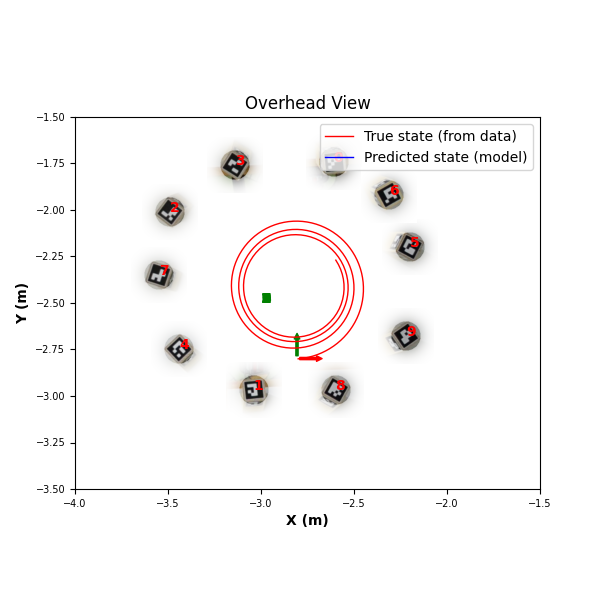

In [6]:
for c in range(control_replay.shape[0]):
    # Set the measurement covariances
    for mes in measurements_replay[c]:
        mes.covariance = sigma_measure 
    
    drive_signal = DriveMeasurement(control_replay[c,0],control_replay[c,1],dt,sigma_drive[0],sigma_drive[1])
    tags = [lm.tag for lm in measurements_replay[c]]
    
    #TODO: Complete this step -----------------------------------------------------
    # Prediction Step
    P, x_bar = predict_step(bot, P, drive_signal)
    # Construct measurement index list
    z, R = construct_R(measurements_replay[c])
    # Update step
    x, P = update_step(bot, P, R, z, x_bar, tags)
    #ENDTODO ----------------------------------------------------------------------
    
    # Set the estimated as next state.
    bot.set_state(x[0], x[1], x[2])
    state[c,:] = np.array(bot.get_state()).flatten()
    # Drive and predict
    robot_cov[c,:,:] = P[0:3,0:3]
    
#Create a visualizer and visualize our state
rend = Renderer.Instance()
rend.initialize(state,measurements_replay, true_state = gt_state,robot_cov=robot_cov, add_aruco=True)

# Grading

Test cases for giving marks:
- q1: assess the `predict_step` function (2 points)
- q2: assess the `construct_R` function (2 points)
- q3: assess the `update_step` function (2 points)
- q4: assess the `state` and `robot_cov` variables (1 point)

In [7]:
import otter
from ece4078.Utility import pretty_print_otter
grader = otter.Notebook(tests_dir = "Practical03_Support/tests")

grader.check_all()
# If the test cases gives you too much messages and it's hard to keep track of, uncomment the following line
# pretty_print_otter(grader.check_all())

predict_func results: All test cases passed!
predict_func - 1 message: Good Job

R_func results: All test cases passed!
R_func - 1 message: Correct R dimension
R_func - 2 message: Filling the number correctly.

update_func results: All test cases passed!
update_func - 1 message: This function ran successfully.
update_func - 2 message: Implemented corrected_x correctly.
update_func - 3 message: Implemented corrected_P correctly.

EKF_results results: All test cases passed!
EKF_results - 1 message: Good Job